In [1]:
import numpy as np
import scipy.signal as signal
import sounddevice as sd
import soundfile as sf
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import pickle
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# Define Basic Voice Activation Detector

In [3]:
class VoiceActivityDetector():   
    def __init__(self, fs):
        self.sample_rate = fs
        self.sample_rate = 44100
        self.speech_on = False
    
        #Spectrum Based:
        self.speech_energy_threshold = 0.6 #60% of energy in voice band
        self.speech_start_band = 300
        self.speech_end_band = 3000
    
    def CheckActivation(self, data):
        speech_band_energy_fraction = self.GetSpeechBandEnergyFraction(data)
        self.speech_on = self.ClassifySpeech(speech_band_energy_fraction)
    
    def FreqInRange(self, f):
        return freq[i] > self.speech_start_band and freq[i] < self.speech_end_band
    
    def GetSpeechBandEnergyFraction(self,data):
        freq, power = signal.periodogram(data, self.sample_rate)
        total_energy = np.sum(power)
        in_range = lambda f : (f > self.speech_start_band) and (f < self.speech_end_band)
        band_energy = sum([power[i] for i in range(len(power)) if in_range(freq[i])]) 
        return band_energy / total_energy
    
    def ClassifySpeech(self, speech_band_energy_fraction):
        return (speech_band_energy_fraction > self.speech_energy_threshold)





In [4]:
[fs, data] = wavfile.read('wav-sample.wav')
VAD = VoiceActivityDetector(fs)

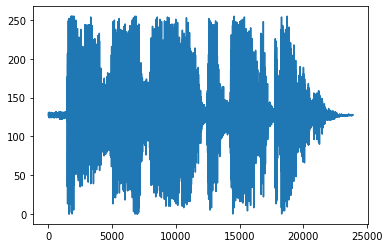

In [6]:
plt.plot(data)
plt.show()

In [7]:
VAD.GetSpeechBandEnergyFraction(data)

0.5657182945982169

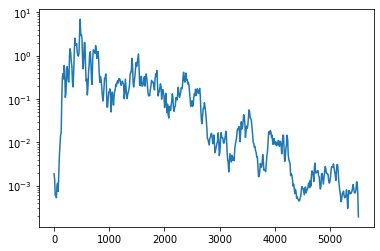

In [8]:
f, Pxx_den = signal.welch(data, fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.show()

# Record Speech Examples:

In [120]:


fs = 44100  # Sample rate
seconds = 30  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
sd.wait()  # Wait until recording is finished

In [121]:
# Save as WAV file - note do this twice once for speech & once for non-speech
wavfile.write('TrainingData/non_speech.wav', fs, myrecording)

In [114]:
fs = 44100  # Sample rate
duration = 0.2  # seconds
sound_recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sound_recording = np.transpose(sound_recording)[0]

In [115]:
freq, power = signal.periodogram(sound_recording, fs)
total_energy = np.sum(power)
in_range = lambda (f) : (f > 300) and (f < 2000)
band_energy = np.sum([power[i] for i in range(len(power)) if in_range(freq[i])]) 
print band_energy / total_energy

0.00922368


In [113]:
power[0]

1.3840417e-22

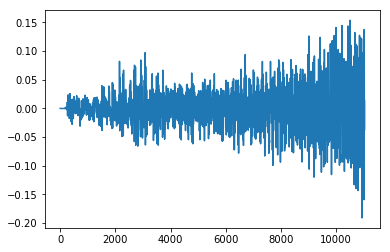

In [111]:
plt.plot(sound_recording)
plt.show()

# Train Model

In [9]:
#Load Sounds:
fs = 44100  # Sample rate
duration = 0.2
[fs, speech_recording] = wavfile.read('TrainingData/speech.wav', )
[fs, ambient_recording] = wavfile.read('TrainingData/non_speech.wav')

In [10]:
np.size(speech_recording[1000:1010,0])

10

In [14]:
def Sound2Blocks(x, fs, block_duration):
    sample_length = int(fs * block_duration)
    n_samples = int(len(x) / sample_length)
    samples = []
    for i in range(n_samples):
        block = x[(i*sample_length):((i+1)*sample_length),0]
        samples.append(block)
    return samples

In [15]:
def ExtractPowerBands(x, fs, band_bins):
    freq, power = signal.periodogram(x, fs)
    total_energy = np.sum(power)
    band_energy_fraction = [0.0] * (len(band_bins))
    band_ind = 0
    for i in range(len(power)):
        if(freq[i]>band_bins[band_ind]):
            band_ind += 1
        band_energy_fraction[band_ind] += power[i]
    normalized_band_energy = [b / total_energy for b in band_energy_fraction]
    return normalized_band_energy

In [16]:
speech_blocks = Sound2Blocks(speech_recording, fs, duration)
non_speech_blocks = Sound2Blocks(ambient_recording,fs, duration)
band_bins = [180, 250, 360, 500, 1000, 2000, 5000, 10000, 25000]
X = []
prior_bands = [0.0]*len(band_bins)
for block in speech_blocks:
    bands = ExtractPowerBands(block, fs, band_bins)
    if(prior_bands[0] != 0.0):
        bands.extend(prior_bands)
        X.append(bands)
    prior_bands = bands[0:len(band_bins)]
    
prior_bands = [0.0]*len(band_bins)
for block in non_speech_blocks:
    bands = ExtractPowerBands(block, fs, band_bins)
    if(prior_bands[0] != 0.0):
        bands.extend(prior_bands)
        X.append(bands)
    prior_bands = bands[0:len(band_bins)]
is_speech = [True] * (len(speech_blocks) - 1)
isnot_speech = [False] * (len(non_speech_blocks) - 1)
is_speech.extend(isnot_speech)

In [17]:
clf = SVC()
clf.fit(X, is_speech)
print(clf.score(X, is_speech))

0.9026845637583892


In [18]:
c_range = np.logspace(-2,10,13)
gamma_range = np.logspace(-9,3,13)
parameter_grid = dict(gamma = gamma_range, C = c_range)

In [19]:
cv = StratifiedShuffleSplit(n_splits = 3, test_size= 0.25)
scoring_metric = metrics.make_scorer(metrics. precision_score)
grid = GridSearchCV(SVC(), param_grid=parameter_grid, cv = cv, scoring=scoring_metric)
grid.fit(X,is_speech)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Fram

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Fram

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Fram

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Fram

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=None, test_size=0.25,
            train_size=None),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer

In [20]:
grid.best_params_

{'C': 1000.0, 'gamma': 0.1}

In [21]:
grid.best_score_

0.8611345436762639

In [22]:
grid.best_estimator_

SVC(C=1000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

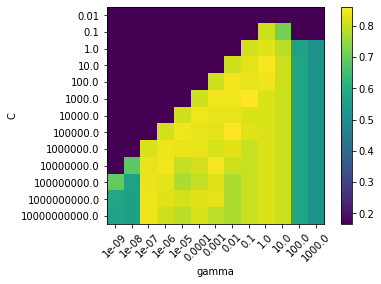

In [23]:
scores = grid.cv_results_['mean_test_score'].reshape(len(c_range), len(gamma_range))
plt.imshow(scores)
plt.xlabel('gamma')
plt.ylabel('C')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation = 45)
plt.yticks(np.arange(len(c_range)), c_range)
plt.colorbar()
plt.show()

## Save Model:

In [24]:
band_bins = [180, 250, 360, 500, 1000, 2000, 5000, 10000, 25000]
prior_bands = [0.0]*len(band_bins)
clf = grid.best_estimator_
clf.fit(X,is_speech)
clf.predict(np.reshape([0.0]*2*len(band_bins),(1,18)))[0]

False

In [256]:
#with open('svm_classifier.pkl', 'wb') as fid:
#    cPickle.dump(clf, fid)

In [25]:
filename = 'svm_classifier_2.pkl'
pickle.dump(clf, open(filename, 'wb'))

# Record Laughter

In [30]:
fs = 44100  # Sample rate
seconds = 10  # Duration of recording

laughter_recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
wavfile.write('laughter.wav', fs, laughter_recording)  # Save as WAV file 